In [1]:
!pip install torch
!pip install torchdiffeq
!pip install torchvision

In [2]:
import numpy as np
import math, shelve
from torch.utils.data import Dataset
from scipy.integrate import solve_ivp
import torch
import torchdiffeq
from collections import OrderedDict

MAX = np.iinfo(np.int32).max

class DampledPendulum(Dataset):
    __default_params = OrderedDict(omega0_square=(2 * math.pi / 12) ** 2, alpha=0.2)

    def __init__(self, path, num_seq, time_horizon, dt, params=None, group='train'):
        super().__init__()
        self.len = num_seq
        self.time_horizon = float(time_horizon)  # total time
        self.dt = float(dt)  # time step
        self.params = OrderedDict()
        if params is None:
            self.params.update(self.__default_params)
        else:
            self.params.update(params)
        self.group = group
        self.data = shelve.open(path)

    def _f(self, t, x):  # coords = [q,p]
        omega0_square, alpha = list(self.params.values())

        q, p = np.split(x, 2)
        dqdt = p
        dpdt = -omega0_square * np.sin(q) - alpha * p
        return np.concatenate([dqdt, dpdt], axis=-1)

    def _get_initial_condition(self, seed):
        np.random.seed(seed if self.group == 'train' else MAX-seed)
        y0 = np.random.rand(2) * 2.0 - 1
        radius = np.random.rand() + 1.3
        y0 = y0 / np.sqrt((y0 ** 2).sum()) * radius
        return y0

    def __getitem__(self, index):
        t_eval = np.arange(0, self.time_horizon, self.dt)
        if self.data.get(str(index)) is None:
            y0 = self._get_initial_condition(index)
            states = solve_ivp(fun=self._f, t_span=(0, self.time_horizon), y0=y0, method='DOP853', t_eval=t_eval, rtol=1e-10).y
            self.data[str(index)] = states
            states = torch.from_numpy(states).float()
        else:
            states = torch.from_numpy(self.data[str(index)]).float()
        return {'states': states, 't': torch.tensor(t_eval).float()}

    def __len__(self):
        return self.len

In [3]:
import torch
import math
from torch.utils.data import DataLoader

def param_pendulum(buffer_filepath, batch_size=25):
    dataset_train_params = {
        'num_seq': 25, 
        'time_horizon': 20,
        'dt': 0.5, 
        'group': 'train',
        'path': buffer_filepath+'_train',
    }

    dataset_test_params = dict()
    dataset_test_params.update(dataset_train_params)
    dataset_test_params['num_seq'] = 25
    dataset_test_params['group'] = 'test'
    dataset_test_params['path'] = buffer_filepath+'_test'

    dataset_train = DampledPendulum(**dataset_train_params)
    dataset_test  = DampledPendulum(**dataset_test_params)

    dataloader_train_params = {
        'dataset'    : dataset_train,
        'batch_size' : batch_size,
        'num_workers': 0,
        'pin_memory' : True,
        'drop_last'  : False,
        'shuffle'    : True,
    }

    dataloader_test_params = {
        'dataset'    : dataset_test,
        'batch_size' : batch_size,
        'num_workers': 0,
        'pin_memory' : True,
        'drop_last'  : False,
        'shuffle'    : False,
    }
    dataloader_train = DataLoader(**dataloader_train_params)
    dataloader_test  = DataLoader(**dataloader_test_params)

    return dataloader_train, dataloader_test         


def init_dataloaders(dataset, buffer_filepath=None):
    assert buffer_filepath is not None
    
    if dataset == 'pendulum':
        return param_pendulum(buffer_filepath)

In [4]:
import collections.abc as collections
import functools
import logging
import random
import warnings
import os
import sys
from typing import Any, Callable, Dict, Optional, TextIO, Tuple, Type, TypeVar, Union, cast

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import init
from torch import Tensor
from torch.nn import Parameter
from datetime import datetime

class Logger(object):
    "Lumberjack class - duplicates sys.stdout to a log file and it's okay"
    def __init__(self, filename, mode="a"):
        self.stdout = sys.stdout
        self.file = open(filename, mode)
        sys.stdout = self

    def __del__(self):
        self.close()

    def __enter__(self):
        pass

    def __exit__(self, *args):
        self.close()

    def write(self, message):
        self.stdout.write(message)
        self.file.write(message)

    def flush(self):
        self.stdout.flush()
        self.file.flush()
        os.fsync(self.file.fileno())

    def close(self):
        if self.stdout != None:
            sys.stdout = self.stdout
            self.stdout = None

        if self.file != None:
            self.file.close()
            self.file = None

def set_requires_grad(nets, requires_grad=False):
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

def fix_seed(seed):
    import numpy as np
    import torch
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)


def pretty_wrap(text, title=None, width=80):
    table = pt.PrettyTable(
        header=title is not None,
    )
    table.field_names = [title]
    for t in text.split('\n'):
        for i in range(0, len(t), width):
            table.add_row([t[i: i + width]])

    return table

def make_basedir(root, timestamp=None, attempts=5):
    """Takes 5 shots at creating a folder from root,
    adding timestamp if desired.
    """
    for i in range(attempts):
        basedir = root
        if timestamp is None:
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
            basedir = os.path.join(basedir, timestamp)
        try:
            os.makedirs(basedir)
            return basedir
        except:
            sleep(0.01)
    raise FileExistsError(root)

################################################################################
# Adapted from http://
################################################################################

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

class CalculateNorm:
    def __init__(self, module, power_iterations=5):
        self.module = module
        assert isinstance(module, nn.ModuleList)
        self.power_iterations = power_iterations
        self._make_params()

    def calculate_spectral_norm(self):
        # Adapted to complex weights
        sigmas = [0. for i in range(len(self.module))]
        for i, module in enumerate(self.module):
            for name, w in module.named_parameters():
                if name.find('bias') == -1 and name.find('beta') == -1:
                    u = self.u[f'{i},{name}']
                    v = self.v[f'{i},{name}']

                    height = w.data.shape[0]
                    for _ in range(self.power_iterations):
                        v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
                        u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

                    sigma = torch.conj(u).dot(w.view(height, -1).mv(v))
                    if torch.is_complex(sigma):
                        sigmas[i] = sigmas[i] + sigma.real ** 2
                    else:
                        sigmas[i] = sigmas[i] + sigma ** 2
        return torch.stack(sigmas)

    def calculate_frobenius_norm(self):
        # Only used for linear case
        sigmas = [0. for i in range(len(self.module))]
        for i, module in enumerate(self.module):
            for name, w in module.named_parameters():
                if name.find('bias') == -1 and name.find('beta') == -1:
                    sigmas[i] = sigmas[i] + torch.norm(w)
        return torch.stack(sigmas)

    def _make_params(self):
        self.u, self.v = dict(), dict()
        for i, module in enumerate(self.module):
            for name, w in module.named_parameters():
                if name.find('bias') == -1 and name.find('beta') == -1:
                    height = w.data.shape[0]
                    width = w.view(height, -1).data.shape[1]

                    u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
                    v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
                    u.data = l2normalize(u.data)
                    v.data = l2normalize(v.data)

                    self.u[f'{i},{name}'] = u
                    self.v[f'{i},{name}'] = v

def init_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            elif init_type == 'default':
                pass
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm') != -1:
            if m.weight is not None:
                init.normal_(m.weight.data, 1.0, init_gain)
            if m.bias is not None:
                init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

################################################################################
# convert_tensor, apply_to_tensor
# 
# built-in functions of pytorch_ignite
# Source: https://github.com/pytorch/ignite/blob/master/ignite/utils.py  
################################################################################

def convert_tensor(
    x: Union[torch.Tensor, collections.Sequence, collections.Mapping, str, bytes],
    device: Optional[Union[str, torch.device]] = None,
    non_blocking: bool = False,
    ) -> Union[torch.Tensor, collections.Sequence, collections.Mapping, str, bytes]:
    """Move tensors to relevant device.
    Args:
        x: input tensor or mapping, or sequence of tensors.
        device: device type to move ``x``.
        non_blocking: convert a CPU Tensor with pinned memory to a CUDA Tensor
            asynchronously with respect to the host if possible
    """

    def _func(tensor: torch.Tensor) -> torch.Tensor:
        return tensor.to(device=device, non_blocking=non_blocking) if device is not None else tensor

    return apply_to_tensor(x, _func)


def apply_to_tensor(
    x: Union[torch.Tensor, collections.Sequence, collections.Mapping, str, bytes], func: Callable
    ) -> Union[torch.Tensor, collections.Sequence, collections.Mapping, str, bytes]:
    """Apply a function on a tensor or mapping, or sequence of tensors.
    Args:
        x: input tensor or mapping, or sequence of tensors.
        func: the function to apply on ``x``.
    """
    return apply_to_type(x, torch.Tensor, func)


def apply_to_type(
    x: Union[Any, collections.Sequence, collections.Mapping, str, bytes],
    input_type: Union[Type, Tuple[Type[Any], Any]],
    func: Callable,
    ) -> Union[Any, collections.Sequence, collections.Mapping, str, bytes]:
    """Apply a function on an object of `input_type` or mapping, or sequence of objects of `input_type`.
    Args:
        x: object or mapping or sequence.
        input_type: data type of ``x``.
        func: the function to apply on ``x``.
    """
    if isinstance(x, input_type):
        return func(x)
    if isinstance(x, (str, bytes)):
        return x
    if isinstance(x, collections.Mapping):
        return cast(Callable, type(x))({k: apply_to_type(sample, input_type, func) for k, sample in x.items()})
    if isinstance(x, tuple) and hasattr(x, "_fields"):  # namedtuple
        return cast(Callable, type(x))(*(apply_to_type(sample, input_type, func) for sample in x))
    if isinstance(x, collections.Sequence):
        return cast(Callable, type(x))([apply_to_type(sample, input_type, func) for sample in x])
    raise TypeError((f"x must contain {input_type}, dicts or lists; found {type(x)}"))

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import statistics

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
# matplotlib.rcParams["figure.dpi"] = 100

_EPSILON = 1e-5

import os, time, io, logging, sys
from functools import partial

from torchvision.utils import make_grid

import collections

from torch.nn import Module
from torch.optim import Optimizer
from torch.utils.data import DataLoader


class BaseExperiment(object):
    def __init__(self, device, path='./exp', seed=None):
        self.device = device
        self.path = make_basedir(path)
            
        if seed is not None:
            fix_seed(seed)

    def training(self, mode=True):
        for m in self.modules():
            m.train(mode)

    def evaluating(self):
        self.training(mode=False)

    def zero_grad(self):
        for optimizer in self.optimizers():
            optimizer.zero_grad()        

    def to(self, device):
        for m in self.modules():
            m.to(device)
        return self

    def modules(self):
        for name, module in self.named_modules():
            yield module

    def named_modules(self):
        for name, module in self._modules.items():
            yield name, module

    def datasets(self):
        for name, dataset in self.named_datasets():
            yield dataset

    def named_datasets(self):
        for name, dataset in self._datasets.items():
            yield name, dataset

    def optimizers(self):
        for name, optimizer in self.named_optimizers():
            yield optimizer

    def named_optimizers(self):
        for name, optimizer in self._optimizers.items():
            yield name, optimizer

    def __setattr__(self, name, value):
        if isinstance(value, Module):
            if not hasattr(self, '_modules'):
                self._modules = collections.OrderedDict()
            self._modules[name] = value
        elif isinstance(value, DataLoader):
            if not hasattr(self, '_datasets'):
                self._datasets = collections.OrderedDict()
            self._datasets[name] = value
        elif isinstance(value, Optimizer):
            if not hasattr(self, '_optimizers'):
                self._optimizers = collections.OrderedDict()
            self._optimizers[name] = value
        else:
            object.__setattr__(self, name, value)

    def __getattr__(self, name):
        if '_modules' in self.__dict__:
            modules = self.__dict__['_modules']
            if name in modules:
                return modules[name]
        if '_datasets' in self.__dict__:
            datasets = self.__dict__['_datasets']
            if name in datasets:
                return datasets[name]
        if '_optimizers' in self.__dict__:
            optimizers = self.__dict__['_optimizers']
            if name in optimizers:
                return optimizers[name]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, name))

    def __delattr__(self, name):
        if name in self._modules:
            del self._modules[name]
        elif name in self._datasets:
            del self._datasets[name]
        elif name in self._optimizers:
            del self._optimizers[name]
        else:
            object.__delattr__(self, name)

def show(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

class LoopExperiment(BaseExperiment):
    def __init__(
        self, train, test=None, root=None, nepoch=10, **kwargs):
        super().__init__(**kwargs)
        self.train = train
        self.test = test
        self.nepoch = nepoch
        self.logger = Logger(filename=os.path.join(self.path, 'log.txt'))
        print(' '.join(sys.argv))

    def train_step(self, batch, val=False):
        self.training()
        batch = convert_tensor(batch, self.device)
        loss, output = self.step(batch)
        with torch.no_grad():
            metric = self.metric(**output, **batch)

        return batch, output, loss, metric

    def val_step(self, batch, val=False):
        self.evaluating()
        with torch.no_grad():
            batch = convert_tensor(batch, self.device)
            loss, output = self.step(batch, backward=False)
            metric = self.metric(**output, **batch)

        return batch, output, loss, metric

    def log(self, epoch, iteration, metrics):
        message = '[{step}][{epoch}/{max_epoch}][{i}/{max_i}]'.format(
            step=epoch *len(self.train)+ iteration+1,
            epoch=epoch+1,
            max_epoch=self.nepoch,
            i=iteration+1,
            max_i=len(self.train)
        )
        for name, value in metrics.items():
            message += ' | {name}: {value:.2e}'.format(name=name, value=value)
            
        print(message)

    def step(self, **kwargs):
        raise NotImplementedError


class APHYNITYExperiment(LoopExperiment):
    def __init__(self, net, optimizer, min_op, lambda_0, tau_2, niter=1, nupdate=100, nlog=10, **kwargs):
        super().__init__(**kwargs)

        self.traj_loss = nn.MSELoss()
        self.net = net.to(self.device)
        self.optimizer = optimizer

        self.min_op = min_op
        self.tau_2 = tau_2
        self.niter = niter
        self._lambda = lambda_0

        self.nlog = nlog
        self.nupdate = nupdate
    
    def lambda_update(self, loss):
        self._lambda = self._lambda + self.tau_2 * loss
    
    def _forward(self, states, t, backward):
        target = states
        y0 = states[:, :, 0]
        pred = self.net(y0, t)
        loss = self.traj_loss(pred, target)
        aug_deriv = self.net.model_aug.get_derivatives(states)

        if self.min_op == 'l2_normalized':
            loss_op = ((aug_deriv.norm(p=2, dim=1) / (states.norm(p=2, dim=1) + _EPSILON)) ** 2).mean()
        elif self.min_op == 'l2':
            loss_op = (aug_deriv.norm(p=2, dim=1) ** 2).mean()

        if backward:
            loss_total = loss * self._lambda + loss_op

            loss_total.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

        loss = {
            'loss': loss,
            'loss_op': loss_op,
        }

        output = {
            'states_pred'     : pred,
        }
        return loss, output

    def step(self, batch, backward=True):
        states = batch['states']
        t = batch['t'][0]
        loss, output = self._forward(states, t, backward)
        return loss, output

    def metric(self, states, states_pred, **kwargs):
        metrics = {}
        metrics['param_error'] = statistics.mean(abs(v1-float(v2))/v1 for v1, v2 in zip(self.train.dataset.params.values(), self.net.get_pde_params().values()))
        metrics.update(self.net.get_pde_params())
        metrics.update({f'{k}_real': v for k, v in self.train.dataset.params.items() if k in metrics})
        return metrics

    def run(self):
        loss_test_min = None
        for epoch in range(self.nepoch): 
            for iteration, data in enumerate(self.train, 0):
                for _ in range(self.niter):
                    _, _, loss, metric = self.train_step(data)

                total_iteration = epoch * (len(self.train)) + (iteration + 1)
                loss_train = loss['loss'].item()
                self.lambda_update(loss_train)

                if total_iteration % self.nlog == 0:
                    self.log(epoch, iteration, loss | metric)

                if total_iteration % self.nupdate == 0:
                    with torch.no_grad():
                        loss_test = 0.
                        for j, data_test in enumerate(self.test, 0):
                            _, output, loss, metric = self.val_step(data_test)
                            
                            # print(data_test["states"][0,0,:].numpy())
                            # print(output["states_pred"][0,0,:].numpy())
                            
                            fig, ax = plt.subplots(1, 5, figsize=(15, 5))
                            fig.suptitle('red is test, blue is pred')
                            
                            for i in range(5):
                                ax[i].plot(data_test["states"][i,0,:].numpy(), "r")
                                ax[i].plot(data_test["states"][i,1,:].numpy(), "r")
                                ax[i].plot(output["states_pred"][i,0,:].numpy(), "b")
                                ax[i].plot(output["states_pred"][i,1,:].numpy(), "b")                    
                                                       
                            
                            plt.show()                           
                            
                            
                            loss_test += loss['loss'].item()
                            
                        loss_test /= j + 1

                        if loss_test_min == None or loss_test_min > loss_test:
                            loss_test_min = loss_test
                            torch.save({
                                'epoch': epoch,
                                'model_state_dict': self.net.state_dict(),
                                'optimizer_state_dict': self.optimizer.state_dict(),
                                'loss': loss_test_min, 
                            }, self.path + f'/model_{loss_test_min:.3e}.pt')
                        loss_test = {
                            'loss_test': loss_test,
                        }
                        print('#' * 80)
                        self.log(epoch, iteration, loss_test | metric)
                        print(f'lambda: {self._lambda}')
                        print('#' * 80)

In [6]:

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from collections import OrderedDict

class DampedPendulumParamPDE(nn.Module):

    def __init__(self, is_complete=False, real_params=None):
        super().__init__()
        self.real_params = real_params
        self.is_complete = is_complete
        self.params_org = nn.ParameterDict({
            'omega0_square_org': nn.Parameter(torch.tensor(0.2)), 
            'alpha_org': nn.Parameter(torch.tensor(0.1)),
        })
        self.params = OrderedDict()
        if real_params is not None:
            self.params.update(real_params)

    def forward(self, state):
        if self.real_params is None:
            self.params['omega0_square'] = self.params_org['omega0_square_org']

        q = state[:,0:1]
        p = state[:,1:2]
        
        if self.is_complete:
            if self.real_params is None:
                self.params['alpha'] = self.params_org['alpha_org']
            (omega0_square, alpha) = list(self.params.values())
            dqdt = p
            dpdt = - omega0_square * torch.sin(q) - alpha * p
        else:
            (omega0_square, ) = list(self.params.values())
            dqdt = p
            dpdt = - omega0_square * torch.sin(q)

        return torch.cat([dqdt, dpdt], dim=1)

class ConvNetEstimator(nn.Module):
    def __init__(self, state_c=2, hidden=16):
        super().__init__()
        kernel_size = 3
        padding = kernel_size // 2
        self.state_c = state_c
        self.net = nn.Sequential(
            nn.Conv2d(state_c, hidden, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(hidden, track_running_stats=False),
            nn.ReLU(True),
            nn.Conv2d(hidden, hidden, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(hidden, track_running_stats=False),
            nn.ReLU(True),
            nn.Conv2d(hidden, state_c, kernel_size=kernel_size, padding=padding),
        )

    def forward(self, x):
        return self.net(x)

    def get_derivatives(self, x):
        batch_size, nc, T, h, w = x.shape
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        x = x.view(batch_size * T, nc, h, w)
        x = self.forward(x)
        x = x.view(batch_size, T, self.state_c, h, w)
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        return x

class MLP(nn.Module):
    def __init__(self, state_c, hidden):
        super().__init__()
        self.state_c = state_c
        self.net = nn.Sequential(
            nn.Linear(state_c, hidden),
            nn.ReLU(True),
            nn.Linear(hidden, hidden),
            nn.ReLU(True),
            nn.Linear(hidden, state_c),
        )
    
    def forward(self, x):
        return self.net(x)

    def get_derivatives(self, x):
        batch_size, nc, T = x.shape
        x = x.permute(0, 2, 1).contiguous()
        x = x.view(batch_size * T, nc)
        x = self.forward(x)
        x = x.view(batch_size, T, self.state_c)
        x = x.permute(0, 2, 1).contiguous()
        return x

In [7]:
import torch.nn as nn
from torchdiffeq import odeint_adjoint, odeint

class DerivativeEstimator(nn.Module):
    def __init__(self, model_phy, model_aug, is_augmented):
        super().__init__()
        self.model_phy = model_phy
        self.model_aug = model_aug
        self.is_augmented = is_augmented

    def forward(self, t, state):
        res_phy = self.model_phy(state)
        if self.is_augmented:
            res_aug = self.model_aug(state)
            return res_phy + res_aug
        else:
            return res_phy

class Forecaster(nn.Module):
    def __init__(self, model_phy, model_aug, is_augmented, method='rk4', options=None):
        super().__init__()

        self.model_phy = model_phy
        self.model_aug = model_aug

        self.derivative_estimator = DerivativeEstimator(self.model_phy, self.model_aug, is_augmented=is_augmented)
        self.method = method
        self.options = options
        self.int_ = odeint 
        
    def forward(self, y0, t):
        # y0 = y[:,:,0]
        res = self.int_(self.derivative_estimator, y0=y0, t=t, method=self.method, options=self.options)
        # res: T x batch_size x n_c (x h x w)
        dim_seq = y0.dim() + 1
        dims = [1, 2, 0] + list(range(dim_seq))[3:]
        return res.permute(*dims)   # batch_size x n_c x T (x h x w)
    
    def get_pde_params(self):
        return self.model_phy.params

################################################################################
# Incomplete Param PDE is used in F_p
# F_a is enabled
################################################################################
/usr/local/lib/python3.9/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-e36c11af-142d-4f58-a312-3a71a0741632.json


/tmp/ipykernel_38293/1235288413.py:234: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  if isinstance(x, collections.Mapping):


[10][10/5000][1/1] | loss: 7.60e-01 | loss_op: 1.48e-02 | param_error: 1.78e-01 | omega0_square: 2.25e-01 | omega0_square_real: 2.74e-01
[20][20/5000][1/1] | loss: 1.46e-01 | loss_op: 1.80e-02 | param_error: 1.77e-01 | omega0_square: 2.26e-01 | omega0_square_real: 2.74e-01


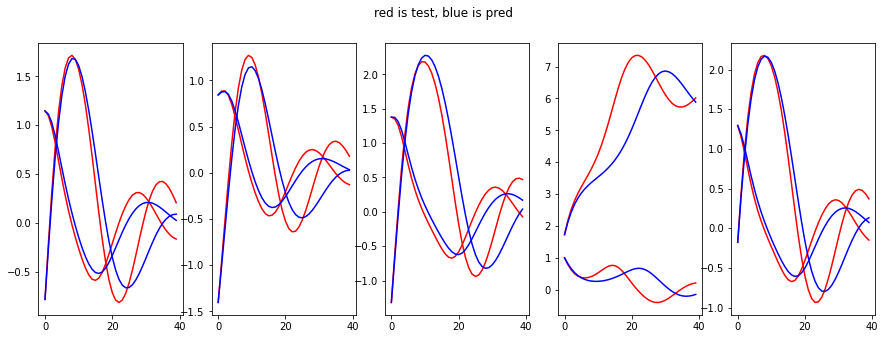

################################################################################
[20][20/5000][1/1] | loss_test: 7.22e-01 | param_error: 1.77e-01 | omega0_square: 2.26e-01 | omega0_square_real: 2.74e-01
lambda: 49.88612884283066
################################################################################
[30][30/5000][1/1] | loss: 3.15e-02 | loss_op: 1.47e-02 | param_error: 1.49e-01 | omega0_square: 2.33e-01 | omega0_square_real: 2.74e-01
[40][40/5000][1/1] | loss: 1.83e-02 | loss_op: 1.46e-02 | param_error: 1.16e-01 | omega0_square: 2.42e-01 | omega0_square_real: 2.74e-01


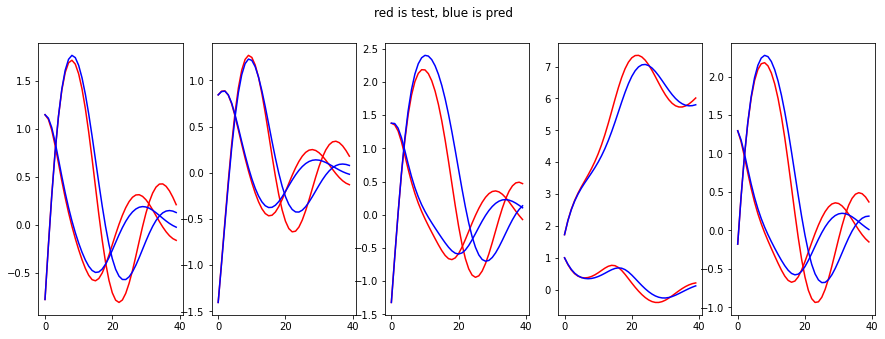

################################################################################
[40][40/5000][1/1] | loss_test: 3.20e-01 | param_error: 1.16e-01 | omega0_square: 2.42e-01 | omega0_square_real: 2.74e-01
lambda: 50.74127043411136
################################################################################
[50][50/5000][1/1] | loss: 1.22e-02 | loss_op: 1.43e-02 | param_error: 9.00e-02 | omega0_square: 2.49e-01 | omega0_square_real: 2.74e-01
[60][60/5000][1/1] | loss: 8.69e-03 | loss_op: 1.37e-02 | param_error: 6.95e-02 | omega0_square: 2.55e-01 | omega0_square_real: 2.74e-01


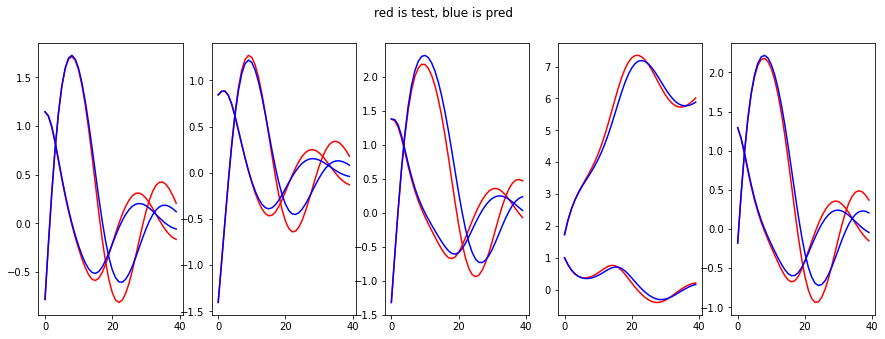

################################################################################
[60][60/5000][1/1] | loss_test: 2.47e-02 | param_error: 6.95e-02 | omega0_square: 2.55e-01 | omega0_square_real: 2.74e-01
lambda: 50.989306286908686
################################################################################
[70][70/5000][1/1] | loss: 6.47e-03 | loss_op: 1.32e-02 | param_error: 5.33e-02 | omega0_square: 2.60e-01 | omega0_square_real: 2.74e-01
[80][80/5000][1/1] | loss: 4.96e-03 | loss_op: 1.26e-02 | param_error: 4.04e-02 | omega0_square: 2.63e-01 | omega0_square_real: 2.74e-01


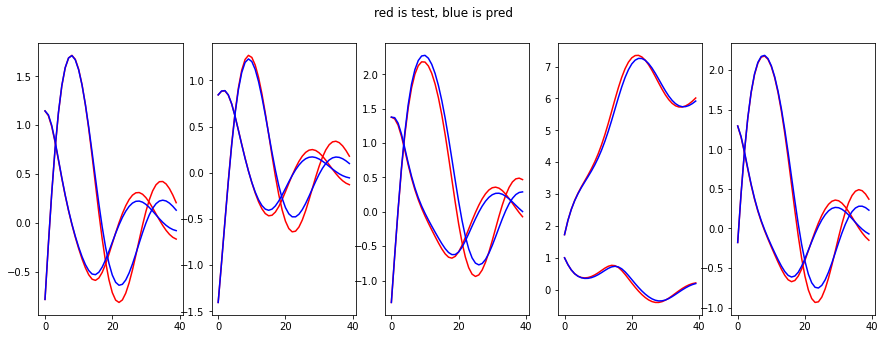

################################################################################
[80][80/5000][1/1] | loss_test: 7.38e-03 | param_error: 4.04e-02 | omega0_square: 2.63e-01 | omega0_square_real: 2.74e-01
lambda: 51.11927543533966
################################################################################
[90][90/5000][1/1] | loss: 3.82e-03 | loss_op: 1.21e-02 | param_error: 2.98e-02 | omega0_square: 2.66e-01 | omega0_square_real: 2.74e-01
[100][100/5000][1/1] | loss: 2.94e-03 | loss_op: 1.15e-02 | param_error: 2.09e-02 | omega0_square: 2.68e-01 | omega0_square_real: 2.74e-01


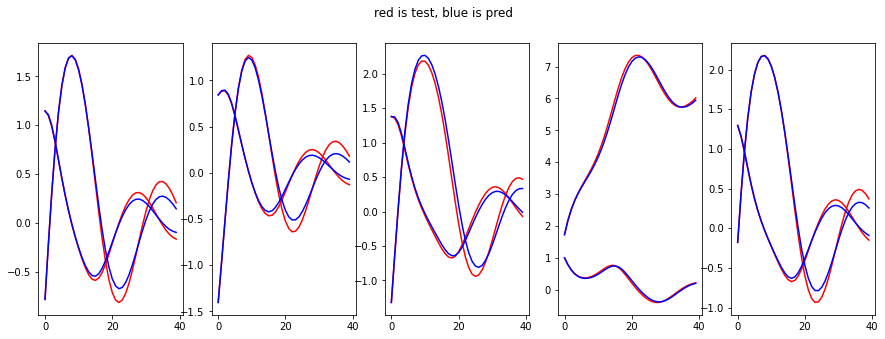

################################################################################
[100][100/5000][1/1] | loss_test: 6.94e-03 | param_error: 2.09e-02 | omega0_square: 2.68e-01 | omega0_square_real: 2.74e-01
lambda: 51.19553668284789
################################################################################
[110][110/5000][1/1] | loss: 2.26e-03 | loss_op: 1.11e-02 | param_error: 1.34e-02 | omega0_square: 2.70e-01 | omega0_square_real: 2.74e-01
[120][120/5000][1/1] | loss: 1.73e-03 | loss_op: 1.07e-02 | param_error: 7.12e-03 | omega0_square: 2.72e-01 | omega0_square_real: 2.74e-01


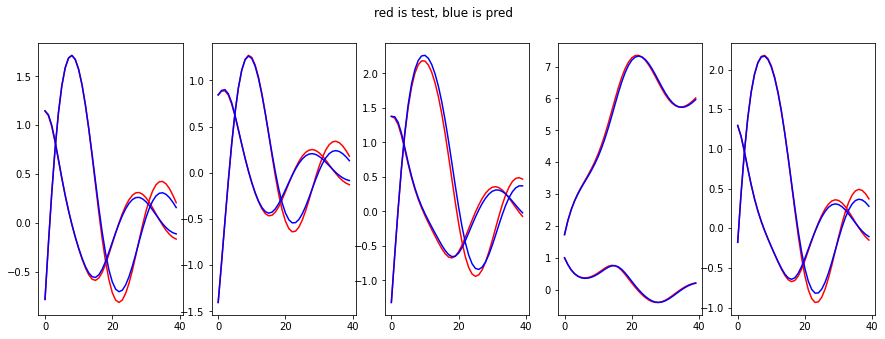

################################################################################
[120][120/5000][1/1] | loss_test: 1.02e-02 | param_error: 7.12e-03 | omega0_square: 2.72e-01 | omega0_square_real: 2.74e-01
lambda: 51.24058696010616
################################################################################
[130][130/5000][1/1] | loss: 1.32e-03 | loss_op: 1.03e-02 | param_error: 1.86e-03 | omega0_square: 2.74e-01 | omega0_square_real: 2.74e-01
[140][140/5000][1/1] | loss: 1.00e-03 | loss_op: 1.00e-02 | param_error: 2.47e-03 | omega0_square: 2.75e-01 | omega0_square_real: 2.74e-01


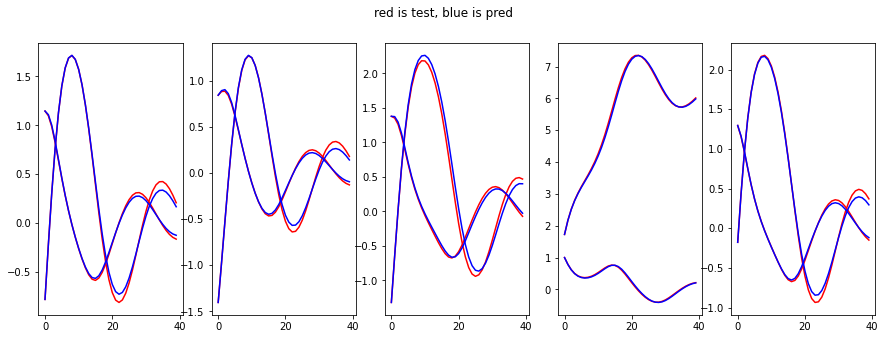

################################################################################
[140][140/5000][1/1] | loss_test: 1.29e-02 | param_error: 2.47e-03 | omega0_square: 2.75e-01 | omega0_square_real: 2.74e-01
lambda: 51.26687137782574
################################################################################
[150][150/5000][1/1] | loss: 7.68e-04 | loss_op: 9.78e-03 | param_error: 5.96e-03 | omega0_square: 2.76e-01 | omega0_square_real: 2.74e-01
[160][160/5000][1/1] | loss: 5.97e-04 | loss_op: 9.55e-03 | param_error: 8.72e-03 | omega0_square: 2.77e-01 | omega0_square_real: 2.74e-01


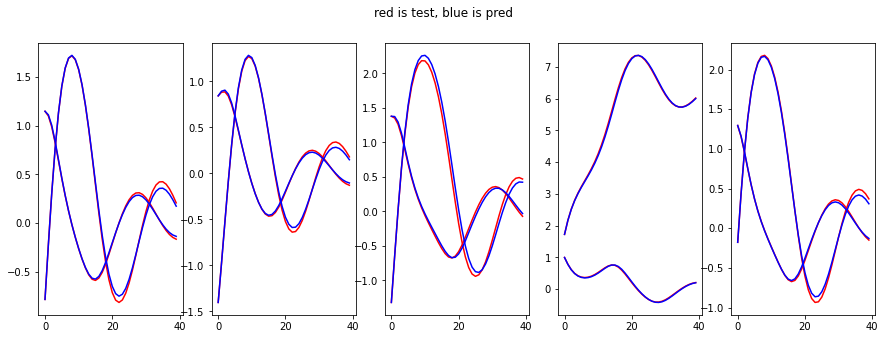

################################################################################
[160][160/5000][1/1] | loss_test: 1.41e-02 | param_error: 8.72e-03 | omega0_square: 2.77e-01 | omega0_square_real: 2.74e-01
lambda: 51.28223860205617
################################################################################
[170][170/5000][1/1] | loss: 4.72e-04 | loss_op: 9.35e-03 | param_error: 1.08e-02 | omega0_square: 2.77e-01 | omega0_square_real: 2.74e-01
[180][180/5000][1/1] | loss: 3.82e-04 | loss_op: 9.19e-03 | param_error: 1.24e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01


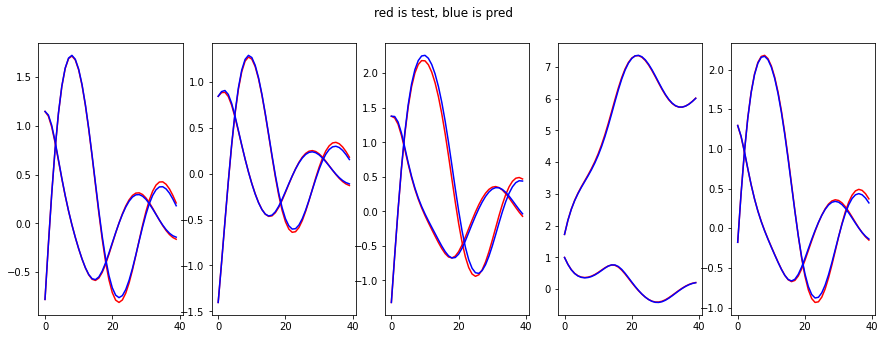

################################################################################
[180][180/5000][1/1] | loss_test: 1.37e-02 | param_error: 1.24e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01
lambda: 51.29169159970479
################################################################################
[190][190/5000][1/1] | loss: 3.17e-04 | loss_op: 9.05e-03 | param_error: 1.35e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01
[200][200/5000][1/1] | loss: 2.68e-04 | loss_op: 8.94e-03 | param_error: 1.41e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01


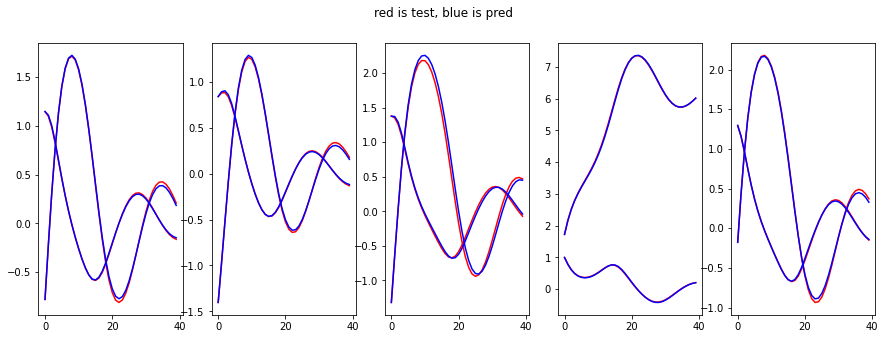

################################################################################
[200][200/5000][1/1] | loss_test: 1.23e-02 | param_error: 1.41e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01
lambda: 51.29802149601164
################################################################################
[210][210/5000][1/1] | loss: 2.31e-04 | loss_op: 8.84e-03 | param_error: 1.45e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01
[220][220/5000][1/1] | loss: 2.03e-04 | loss_op: 8.76e-03 | param_error: 1.46e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01


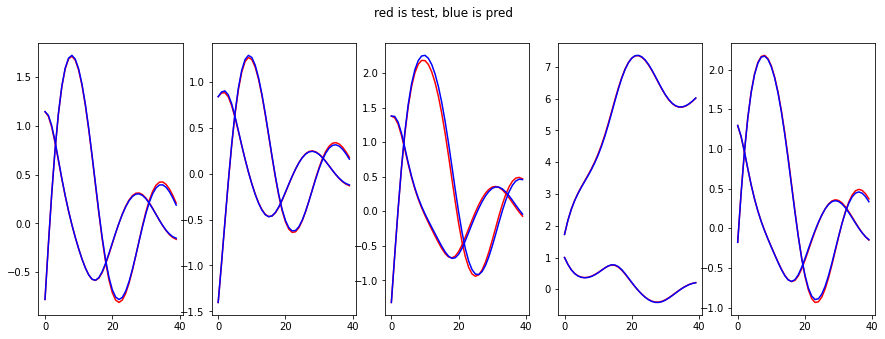

################################################################################
[220][220/5000][1/1] | loss_test: 1.08e-02 | param_error: 1.46e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01
lambda: 51.30264432974218
################################################################################
[230][230/5000][1/1] | loss: 1.81e-04 | loss_op: 8.69e-03 | param_error: 1.45e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01
[240][240/5000][1/1] | loss: 1.63e-04 | loss_op: 8.63e-03 | param_error: 1.42e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01


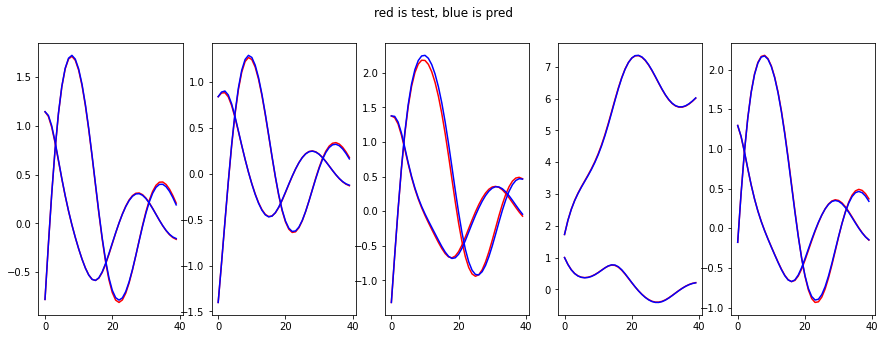

################################################################################
[240][240/5000][1/1] | loss_test: 9.47e-03 | param_error: 1.42e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01
lambda: 51.306260901503265
################################################################################
[250][250/5000][1/1] | loss: 1.48e-04 | loss_op: 8.58e-03 | param_error: 1.39e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01
[260][260/5000][1/1] | loss: 1.35e-04 | loss_op: 8.54e-03 | param_error: 1.34e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01


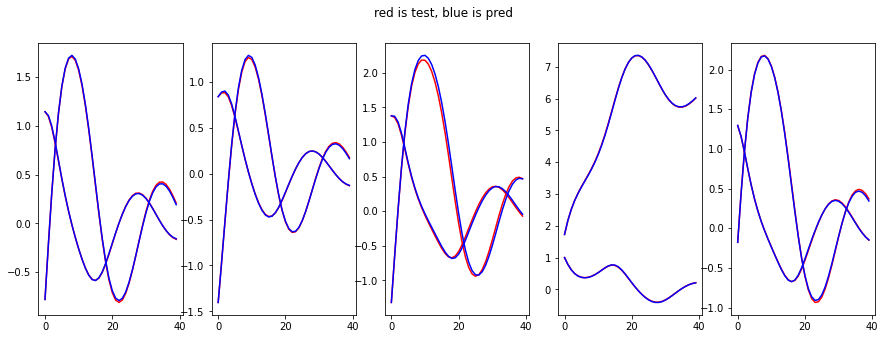

################################################################################
[260][260/5000][1/1] | loss_test: 8.24e-03 | param_error: 1.34e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01
lambda: 51.309211279294686
################################################################################
[270][270/5000][1/1] | loss: 1.23e-04 | loss_op: 8.50e-03 | param_error: 1.29e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01
[280][280/5000][1/1] | loss: 1.13e-04 | loss_op: 8.47e-03 | param_error: 1.23e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01


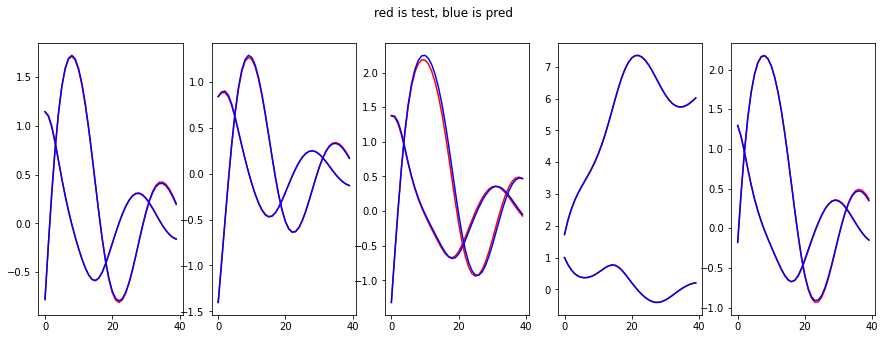

################################################################################
[280][280/5000][1/1] | loss_test: 7.23e-03 | param_error: 1.23e-02 | omega0_square: 2.78e-01 | omega0_square_real: 2.74e-01
lambda: 51.31167082150205
################################################################################
[290][290/5000][1/1] | loss: 1.04e-04 | loss_op: 8.44e-03 | param_error: 1.17e-02 | omega0_square: 2.77e-01 | omega0_square_real: 2.74e-01
[300][300/5000][1/1] | loss: 9.55e-05 | loss_op: 8.41e-03 | param_error: 1.10e-02 | omega0_square: 2.77e-01 | omega0_square_real: 2.74e-01


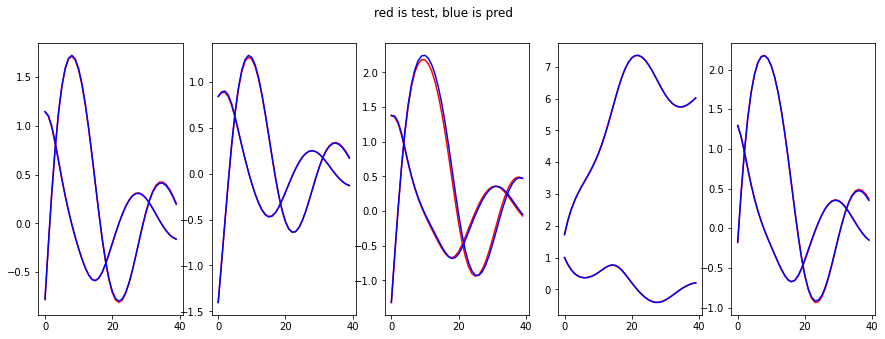

################################################################################
[300][300/5000][1/1] | loss_test: 6.36e-03 | param_error: 1.10e-02 | omega0_square: 2.77e-01 | omega0_square_real: 2.74e-01
lambda: 51.31374280054297
################################################################################
[310][310/5000][1/1] | loss: 8.80e-05 | loss_op: 8.38e-03 | param_error: 1.04e-02 | omega0_square: 2.77e-01 | omega0_square_real: 2.74e-01
[320][320/5000][1/1] | loss: 8.12e-05 | loss_op: 8.36e-03 | param_error: 9.74e-03 | omega0_square: 2.77e-01 | omega0_square_real: 2.74e-01


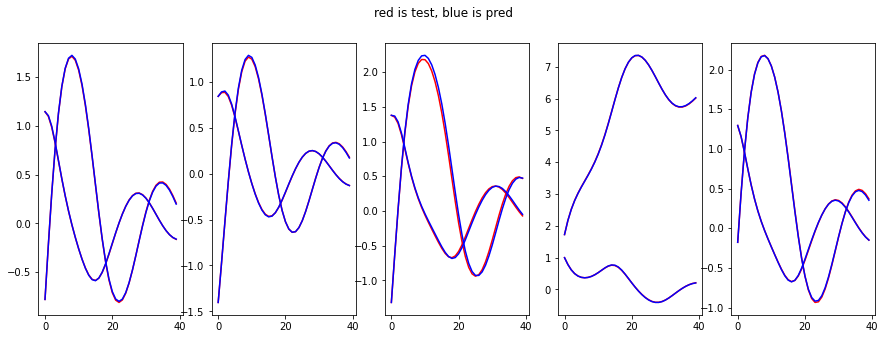

################################################################################
[320][320/5000][1/1] | loss_test: 5.64e-03 | param_error: 9.74e-03 | omega0_square: 2.77e-01 | omega0_square_real: 2.74e-01
lambda: 51.31549880075909
################################################################################
[330][330/5000][1/1] | loss: 7.50e-05 | loss_op: 8.34e-03 | param_error: 9.11e-03 | omega0_square: 2.77e-01 | omega0_square_real: 2.74e-01
[340][340/5000][1/1] | loss: 6.94e-05 | loss_op: 8.32e-03 | param_error: 8.49e-03 | omega0_square: 2.76e-01 | omega0_square_real: 2.74e-01


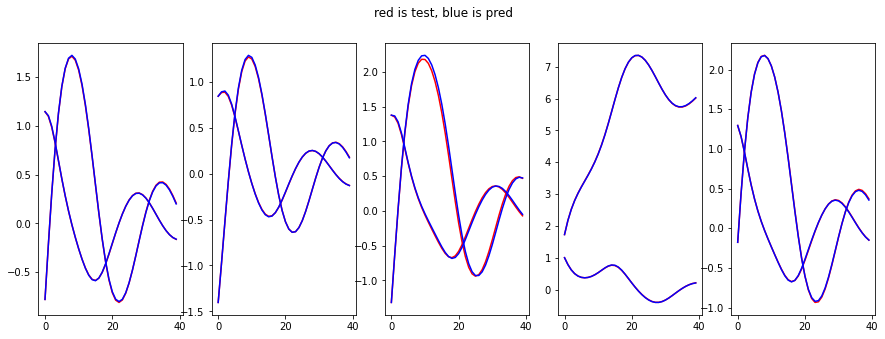

################################################################################
[340][340/5000][1/1] | loss_test: 5.02e-03 | param_error: 8.49e-03 | omega0_square: 2.76e-01 | omega0_square_real: 2.74e-01
lambda: 51.31699552754435
################################################################################
[350][350/5000][1/1] | loss: 6.43e-05 | loss_op: 8.30e-03 | param_error: 7.88e-03 | omega0_square: 2.76e-01 | omega0_square_real: 2.74e-01


In [ ]:
from torch import optim
import os, sys, argparse

__doc__ = '''Training APHYNITY.'''

__name__ = '__main__'

# def cmdline_args():
#         # Make parser object
#     p = argparse.ArgumentParser(description=__doc__, formatter_class=argparse.RawTextHelpFormatter)
    
#     p.add_argument("dataset", type=str,
#                    help='''choose dataset: 
#     'rd' - Reaction-diffusion equation
#     'wave' - Wave equation
#     'pendulum' - Pendulum
#     ''')
#     p.add_argument("-r", "--root", type=str, default='./exp',
#                    help='''root path for the experiments. (default: ./exp)''')
#     p.add_argument("-p", "--phy", type=str, default='incomplete',
#                    help='''choose physical model type: 
#     --phy incomplete - Incomplete Param PDE (default)
#     --phy complete - Complete Param PDE
#     --phy true - True PDE
#     --phy none - No physics
#     ''')
#     p.add_argument("--aug", action=argparse.BooleanOptionalAction, default=True,
#                    help='''enable augmentation: 
#     --aug - With NN augmentaion (default)
#     --no-aug - Without NN augmentation
#     ''')
#     p.add_argument('-d', '--device', type=str, default='cpu',
#                    help='''choose device:
#     'cpu' - CPU only (default)
#     'cuda:X' - CUDA device.''')
#     return p.parse_args()

def train_leads(dataset_name, model_phy_option, model_aug_option, path, device):
    train, test = init_dataloaders(dataset_name, os.path.join(path, dataset_name))

#     if dataset_name == 'rd':
#         if model_phy_option == 'incomplete':
#             model_phy = ReactionDiffusionParamPDE(dx=train.dataset.dx, is_complete=False, real_params=None)
#         elif model_phy_option == 'complete':
#             model_phy = ReactionDiffusionParamPDE(dx=train.dataset.dx, is_complete=True, real_params=None)
#         elif model_phy_option == 'true':
#             model_phy = ReactionDiffusionParamPDE(dx=train.dataset.dx, is_complete=True, real_params=train.dataset.params)
        
#         model_aug = ConvNetEstimator(state_c=2, hidden=16)
#         net = Forecaster(model_phy=model_phy, model_aug=model_aug, is_augmented=model_aug_option)

#         lambda_0 = 1.0
#         tau_1 = 1e-3
#         tau_2 = 1e-3
#         niter = 1
#         min_op = 'l2'

#     if dataset_name == 'wave':
#         if model_phy_option == 'incomplete':
#             model_phy = DampedWaveParamPDE(is_complete=False, real_params=None)
#         elif model_phy_option == 'complete':
#             model_phy = DampedWaveParamPDE(is_complete=True, real_params=None)
#         elif model_phy_option == 'true':
#             model_phy = DampedWaveParamPDE(is_complete=True, real_params=train.dataset.params)
        
#         model_aug = ConvNetEstimator(state_c=2, hidden=16)
#         net = Forecaster(model_phy=model_phy, model_aug=model_aug, is_augmented=model_aug_option)

#         lambda_0 = 1.0
#         tau_1 = 1e-4
#         tau_2 = 1e-3
#         niter = 3
#         min_op = 'l2'

    if dataset_name == 'pendulum':
        if model_phy_option == 'incomplete':
            model_phy = DampedPendulumParamPDE(is_complete=False, real_params=None)
        elif model_phy_option == 'complete':
            model_phy = DampedPendulumParamPDE(is_complete=True, real_params=None)
        elif model_phy_option == 'true':
            model_phy = DampedPendulumParamPDE(is_complete=True, real_params=train.dataset.params)
        
        model_aug = MLP(state_c=2, hidden=200)
        init_weights(model_aug, init_type='orthogonal', init_gain=0.2)
        net = Forecaster(model_phy=model_phy, model_aug=model_aug, is_augmented=model_aug_option)

        lambda_0 = 1.0
        tau_1 = 1e-3
        tau_2 = 1
        niter = 5
        min_op = 'l2_normalized'
    
    optimizer = optim.Adam(net.parameters(), lr=tau_1, betas=(0.9, 0.999))
    experiment = APHYNITYExperiment(
            train=train, test=test, net=net, optimizer=optimizer, 
            min_op=min_op, lambda_0=lambda_0, tau_2=tau_2, niter=niter, nlog=10,
            nupdate=20, nepoch=5000, path=path, device=device
        )
    experiment.run()

if __name__ == '__main__':
    
    if sys.version_info<(3,7,0):
        sys.stderr.write("You need python 3.7 or later to run this script.\n")
        sys.exit(1)
        
    # args = cmdline_args()
    path = os.path.join("./exp", "pendulum")
    os.makedirs(path, exist_ok=True)
    
    option_dict = {
        'incomplete': 'Incomplete Param PDE',
        'complete': 'Complete Param PDE',
        'true': 'True PDE',
        'none': 'No physics'
    }
    print('#' * 80)
    print('#', option_dict['incomplete'], 'is used in F_p')
    print('#', 'F_a is', 'enabled' )
    print('#' * 80)
    train_leads("pendulum", model_phy_option='incomplete', model_aug_option= True, path=path, device='cpu')

In [ ]:
# dataset_train_params2 = {
#         'num_seq': 25, 
#         'time_horizon': 100,
#         'dt': 0.5, 
#         'group': 'train',
#         'path':'./'+'_test'
#     }

# dataset_train = DampledPendulum(**dataset_train_params2)

# new_x = dataset_train.__getitem__(3)

# print(new_x["states"].numpy())
                                  

# %matplotlib inline

# from matplotlib import pyplot as plt

# plt.plot(new_x["states"][0,:].numpy())
# plt.plot(new_x["states"][1,:].numpy())
# plt.show()